In [148]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import t
import warnings
warnings.filterwarnings("ignore")

In [149]:
trading_symbols = np.array(['STXRAF.JO', 'CTOP50.JO','ETF5IT.JO', 'STXCHN.JO' ])
for symbol in trading_symbols:
    stock = yf.Ticker(symbol)
    historical_data = stock.history(period= '2y')
    closing_prices = historical_data['Close']/100
    if not closing_prices.empty:
        current_price = closing_prices.iloc[-1]
        print(f"Current price for {symbol}: {current_price}")
    else:
        print(f"Could not retrieve data for {symbol}")

Current price for STXRAF.JO: 31.5
Current price for CTOP50.JO: 42.23
Current price for ETF5IT.JO: 34.66
Current price for STXCHN.JO: 56.49


In [150]:
# satrix RAFI
stock = yf.Ticker('STXRAF.JO',)
historical_data = stock.history(period= '2y')
stock1 = historical_data/100
# 10x Top50 ETF
stock = yf.Ticker('CTOP50.JO')
historical_data = stock.history(period= '2y')
stock2 = historical_data/100
# invest s&p500 info tech index
stock = yf.Ticker('ETF5IT.JO')
historical_data = stock.history(period= '2y')
stock3 = historical_data/100
# satrix MSCI china
stock = yf.Ticker('STXCHN.JO')
historical_data = stock.history(period= '2y')
stock4 = historical_data/100

In [151]:
df = pd.DataFrame({'STXRAF.JO': stock1['Close'], 'CTOP50.JO': stock2['Close'], 'ETF5IT.JO': stock3['Close'], 'STXCHN.JO': stock4['Close']})

In [152]:
df.describe()

,STXRAF.JO,CTOP50.JO,ETF5IT.JO,STXCHN.JO
count,500.000000,500.000000,500.000000,500.000000
mean,24.168226,33.337671,27.668238,42.193132
std,2.390124,3.424306,3.751464,6.194987
min,20.654673,27.921465,19.235850,32.568701
25%,22.182176,30.130784,25.440000,36.658250
50%,23.837147,33.183944,27.825000,40.875000
75%,24.887634,34.932863,30.275000,48.222500
max,31.500000,42.250000,34.930000,57.080000


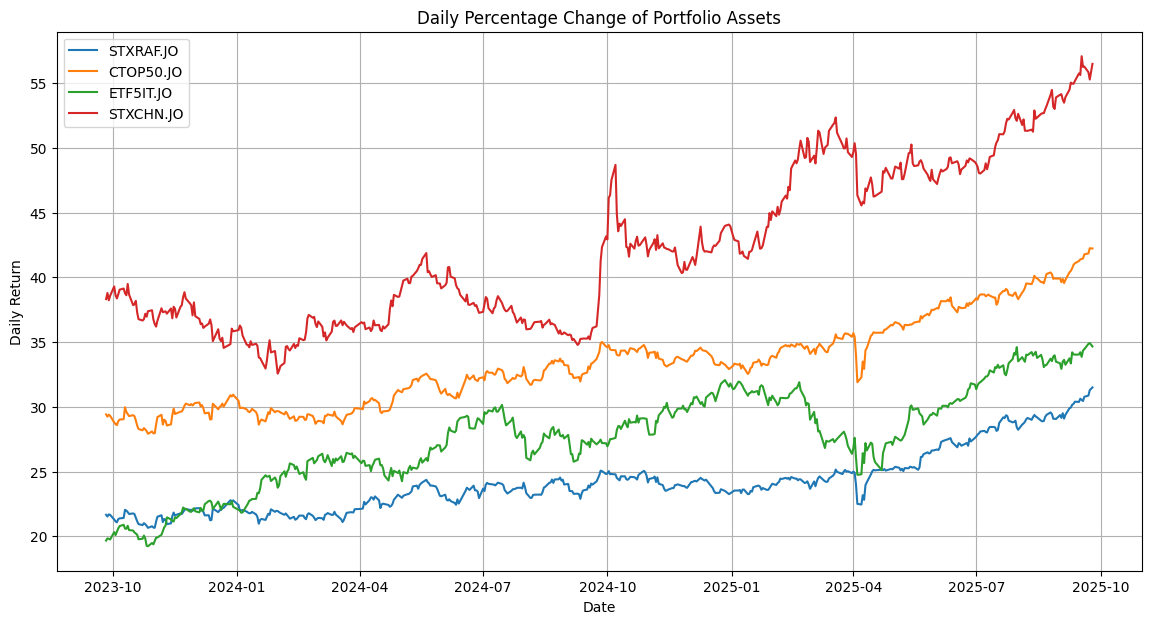

In [153]:
rolling = 10
plt.figure(figsize=(14,7))
plt.plot(df.index, df)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Percentage Change of Portfolio Assets')
plt.legend(df.columns)
plt.show()

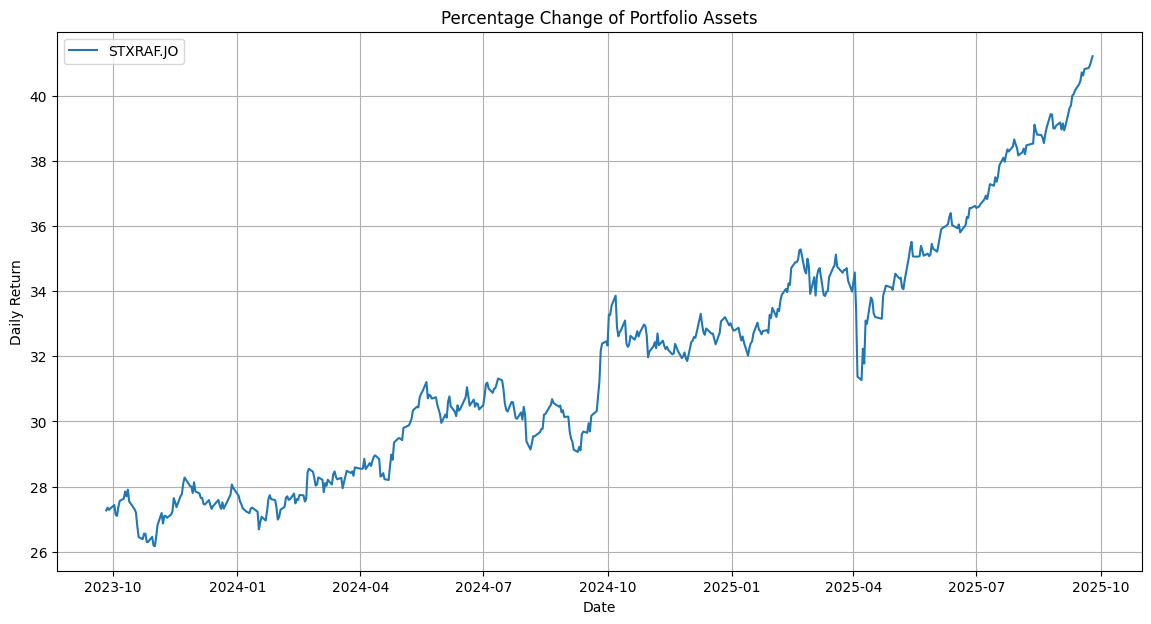

In [154]:
portfolio = (stock1 + stock2 + stock3+ stock4)/4
rolling = 10
plt.figure(figsize=(14,7))
plt.plot(df.index, portfolio['Close'])
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Percentage Change of Portfolio Assets')
plt.legend(df.columns)
plt.show()

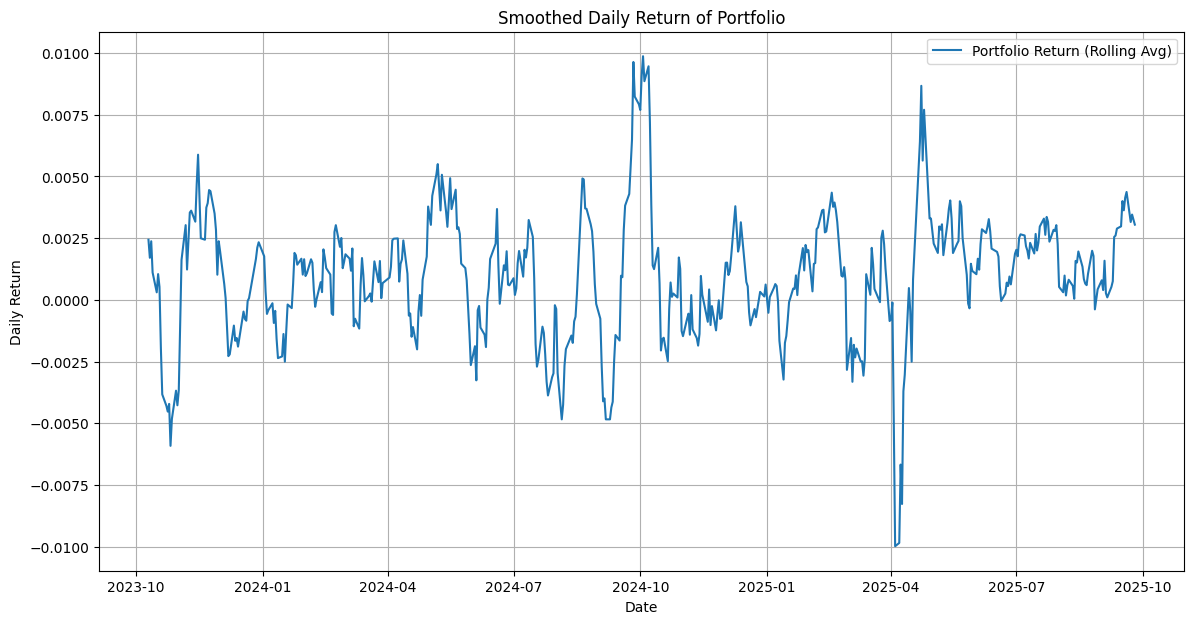

In [155]:
# Calculate daily percentage change for each asset
returns = df[['CTOP50.JO', 'ETF5IT.JO', 'STXCHN.JO', 'STXRAF.JO']].pct_change()

# Average the daily returns to get portfolio return
ports = returns.mean(axis=1)

# Optional: apply rolling average to smooth the line
rolling = 10
ports_rolling = ports.rolling(rolling).mean()

# Plotting
plt.figure(figsize=(14,7))
plt.plot(df.index, ports_rolling, label='Portfolio Return (Rolling Avg)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Smoothed Daily Return of Portfolio')
plt.legend()
plt.show()


<Axes: >

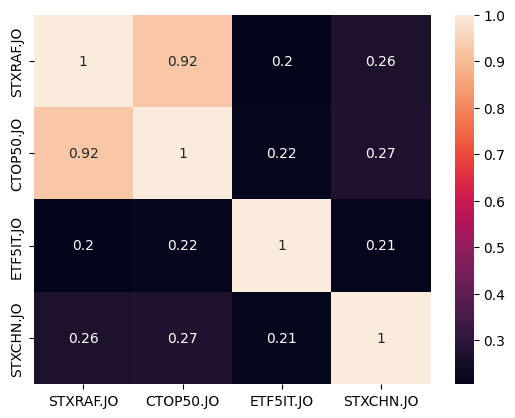

In [156]:
# correlation between returns
sb.heatmap(df.pct_change().corr(), annot=True)


In [157]:
# portfolio's total return
portfolio.pct_change().dropna().sum()*100

,0
Open,0.0
High,0.0
Low,0.0
Close,0.0
Volume,0.0
Dividends,0.0
Stock Splits,0.0


In [158]:
df.pct_change().sum()*100

,0
STXRAF.JO,40.120831
CTOP50.JO,38.367249
ETF5IT.JO,62.298456
STXCHN.JO,44.433502


<Axes: >

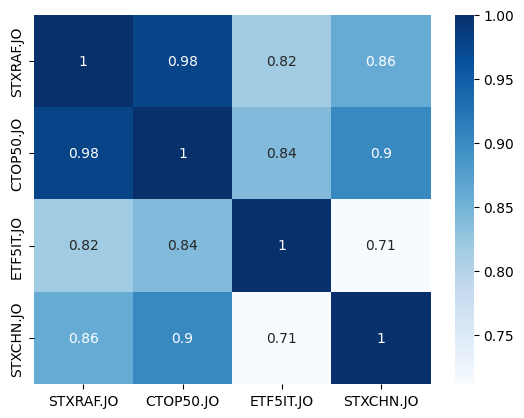

In [159]:
# correlation between the stocks
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [160]:
def calculate_returns(price_data):
    return price_data.pct_change().dropna()

def portfolio_metrics(weights, returns):
    weights = np.array(weights)
    # Expected returns (mean of daily returns)
    mean_returns = returns.mean()
    # Covariance matrix
    cov_matrix = returns.cov()
    # Portfolio expected return
    port_return = np.dot(weights, mean_returns)
    return {
        "Expected Return (daily)": port_return,
    }
prices = df

# 2. Calculate returns
returns = calculate_returns(prices)

# 3. Define portfolio weights (must sum to 1)
weights = [1/4, 1/4, 1/4, 1/4]

# 4. Calculate portfolio metrics
results = portfolio_metrics(weights, returns)
annual_return = results["Expected Return (daily)"] * 252 * 100


In [161]:
# Drift independent volatility estimation

    # Overnight (Close-to-Open) returns
overnight_returns = np.log(portfolio['Open'] / portfolio['Close'].shift(1)).dropna()
var_overnight = overnight_returns.var(ddof=1)

    # Intraday (Open-to-Close) returns
intraday_returns = np.log(portfolio['Close'] / portfolio['Open']).dropna()
var_intraday = intraday_returns.var(ddof=1)

    # Rogers-Satchell volatility
log_hi_open = np.log(portfolio['High'] / portfolio['Open'])
log_hi_close = np.log(portfolio['High'] / portfolio['Close'])
log_lo_open = np.log(portfolio['Low'] / portfolio['Open'])
log_lo_close = np.log(portfolio['Low'] / portfolio['Close'])
rs_terms = log_hi_open * log_hi_close + log_lo_open * log_lo_close
var_rs = rs_terms.mean()
window = len(portfolio['Close'])
k = 0.34 / (1.34 + (window + 1) / (window - 1))

sigma_oc = intraday_returns.var()
sigma_co = overnight_returns.var()
sigma_rs = rs_terms.mean()

    # Yang-Zhang variance
yz_var = sigma_co + k * sigma_oc + (1 - k) * sigma_rs

annual_std = np.sqrt(yz_var)* np.sqrt(252)

In [162]:
print("Optimal Weights:", weights)
print("Annualized Return:", round(annual_return, 4))
print("Annualized Std Dev:", round(annual_std, 4))
print("Portfolio Expected Daily Return:", round(results["Expected Return (daily)"], 6))


Optimal Weights: [0.25, 0.25, 0.25, 0.25]
Annualized Return: 23.3845
Annualized Std Dev: 0.2321
Portfolio Expected Daily Return: 0.000928


Cumulative Portfolio Simulation Results
Mean Final Value: R30936.42
Total Contributed: R24000.00
95% CI(t-distribution): [R30811.08, R31061.75]


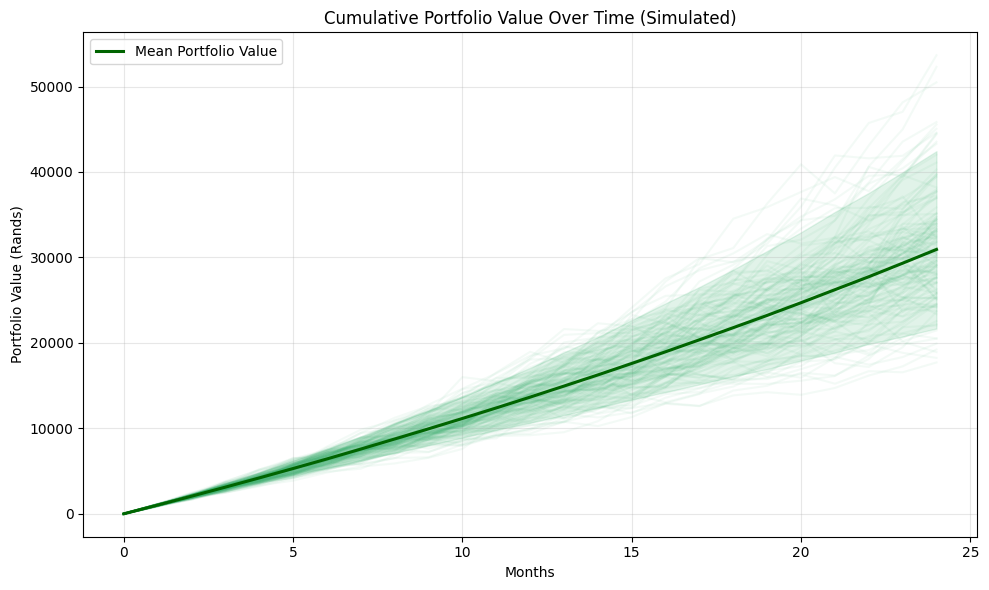

In [165]:
# Monte carlo simulation
# 1. Simulation Parameters

monthly_contribution = 1000
investment_months = 24
n_simulations = 10000
initial_value = 0

# Example daily return and volatility (adjust as needed)
daily_return = results["Expected Return (daily)"]
daily_volatility = np.sqrt(yz_var)

# Convert to monthly
monthly_return = (1 + daily_return)**21 - 1
monthly_volatility = daily_volatility * np.sqrt(21)

# 2. Simulate Cumulative Portfolio Paths
np.random.seed(42)
portfolio_paths = np.zeros((n_simulations, investment_months + 1))  # +1 for initial value

for i in range(n_simulations):
    monthly_returns = np.random.normal(monthly_return, monthly_volatility, investment_months)
    value = initial_value
    portfolio_paths[i, 0] = value  # Month 0
    for j in range(investment_months):
        value = (value + monthly_contribution) * (1 + monthly_returns[j])
        portfolio_paths[i, j + 1] = value

# 3. Final Portfolio Stats
final_values = portfolio_paths[:, -1]
mean_final = final_values.mean()
std_final = final_values.std(ddof=1)
total_contributed = initial_value + monthly_contribution * investment_months

# 4. 95% Confidence Interval (t-distribution)
dof = n_simulations - 1
t_crit = t.ppf(0.975, dof)
std_error = std_final / np.sqrt(n_simulations)

ci_lower = mean_final - t_crit * std_error
ci_upper = mean_final + t_crit * std_error

# 5. Output Results
print("Cumulative Portfolio Simulation Results")
print(f"Mean Final Value: R{mean_final:.2f}")
print(f"Total Contributed: R{total_contributed:.2f}")
print(f"95% CI(t-distribution): [R{ci_lower:.2f}, R{ci_upper:.2f}]")

# 6. Plot Portfolio Paths
plt.figure(figsize=(10, 6))
subset = 150
idx = np.random.choice(n_simulations, size=subset, replace=False)
for i in idx:
    plt.plot(range(investment_months + 1), portfolio_paths[i], color='mediumseagreen', alpha=0.06)

mean_path = portfolio_paths.mean(axis=0)
p5 = np.percentile(portfolio_paths, 5, axis=0)
p95 = np.percentile(portfolio_paths, 95, axis=0)

plt.fill_between(range(investment_months + 1), p5, p95, color='mediumseagreen', alpha=0.15)
plt.plot(range(investment_months + 1), mean_path, color='darkgreen', lw=2.2, label='Mean Portfolio Value')

plt.title("Cumulative Portfolio Value Over Time (Simulated)")
plt.xlabel("Months")
plt.ylabel("Portfolio Value (Rands)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
